In [71]:
import sys
from pathlib import Path

main_path = Path().absolute().parent
sys.path.append(str(main_path))

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import shap
import numpy as np
import pandas as pd
from IPython.display import display

from fge import Dataset, ModelBuilder, TreeBuilder
shap.initjs()

# Cache

In [72]:
import pickle
import os
from collections import defaultdict
from tqdm.notebook import tqdm

def load_cache(cache_path, dataset_names):
    cache = defaultdict()
    system = '_win' if os.name == 'nt' else ''
    for ds_name in dataset_names:
        with (cache_path / f'{ds_name}{system}.pickle').open('rb') as file:
            res = pickle.load(file)
        cache[ds_name] = res
        # dataset = cache[ds_name]['dataset']
        # explainer = cache[ds_name]['explainer']
        # data = dataset.data['X_train']
        # sv = explainer.shap_values(data)
        # cache[ds_name]['shap_values'] = sv
    return cache
dataset_names = ['titanic', 'adult', 'boston', 'california']
cache = load_cache(Path('../cache').resolve() / 'onehot_nointercept', dataset_names=dataset_names)

score_method_list = ['abs', 'abs_interaction', 'ratio']
n_select_scores_list = [5, 10]
n_select_gap_list = [5, 10]
nodes_to_run_method_list = ['random', 'sort', 'full']
filter_method_list = ['random', 'sort', 'prob']
exps = list(itertools.product(
    score_method_list, 
    n_select_scores_list,
    n_select_gap_list, 
    nodes_to_run_method_list, 
    filter_method_list
))

In [75]:
exp_name = 'abs_5_5_sort_prob'
ds_name = 'titanic'

In [76]:
cache[ds_name]['trees'][exp_name]

{'t': [0+6+5+3+1+4+2+7(v=7.3742, i=1.9662)
  ├── 0+6+5+3+1+4+2(v=6.6988, i=1.6980)
  │   ├── 0+6+5+3+1+4(v=4.7285, i=0.9383)
  │   │   ├── 0+6+5+3+1(v=4.4638, i=0.8413)
  │   │   │   ├── 0+6+5+3(v=2.0587, i=0.2825)
  │   │   │   │   ├── 0+6+5(v=1.7087, i=0.2010)
  │   │   │   │   │   ├── 0+6(v=0.9260, i=0.0177)
  │   │   │   │   │   │   ├── 0(v=0.6829, i=0.0000)
  │   │   │   │   │   │   └── 6(v=0.2076, i=0.0000)
  │   │   │   │   │   └── 5(v=0.4162, i=0.0000)
  │   │   │   │   └── 3(v=0.1869, i=0.0000)
  │   │   │   └── 1(v=1.2874, i=0.0000)
  │   │   └── 4(v=0.0709, i=0.0000)
  │   └── 2(v=0.4508, i=0.0000)
  └── 7(v=0.1391, i=0.0000)],
 'gaps': [(1, 0.0),
  (2, -0.01388888888888884),
  (3, -0.01388888888888884),
  (4, -0.01388888888888884),
  (5, -0.01388888888888884),
  (6, -0.01388888888888884),
  (7, -0.01388888888888884)],
 'time': '0 m, 2.02 s'}

In [3]:
tree_gaps = []
prog_bar = tqdm(total=len(dataset_names)*len(exps))
for ds_name in dataset_names:
    dataset = cache[ds_name]['dataset']
    for e in exps:
        exp_name = '_'.join(map(lambda x: str(x), e))
        # get tree
        # tree = cache[ds_name]['trees'][exp_name]['t'][-1]
        gaps = cache[ds_name]['trees'][exp_name]['gaps']
        # img
        # img = tree.show_tree(dataset.feature_names)
        # all_tree_data[ds_name]['img'][exp_name] = img
        # gaps
        for i, g in gaps:
            tree_gaps.append( (ds_name, exp_name, i, g) )
        # prog_bar
        prog_bar.update(1)
prog_bar.close()
df = pd.DataFrame(tree_gaps, columns=['dataset', 'exp_name', 'step', 'gaps'])
df.to_csv(Path('../cache').resolve() / 'all_results.csv', encoding='utf-8', index=False)

  0%|          | 0/432 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(x='step', y='gaps', hue='exp_name', data=df_draw)

In [ ]:
ds_name= 'adult'
dataset = cache[ds_name]['dataset']
siv = cache[ds_name]['siv']
shap_values = cache[ds_name]['shap_values']
explainer = cache[ds_name]['explainer']
features = dataset.data['X_train']
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000], features.iloc[:1000])

In [ ]:
dataset.data['X_train']

In [ ]:
# from fge.dataset import ames_house_prices
# dataset = ames_house_prices(data_home='../data', as_frame=True, display=False)

seed = 8
dataset = Dataset(dataset_name='ames', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.1, max_depth=8, subsample=1.0, seed=seed, num_rounds=300)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

In [ ]:
group_id = None
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
# get tree from all train dataset
trees = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions, 
    n_select_scores=10,  # select nodes_to_run & keys to filter 
    n_select_gap=5, 
    max_iter=35,
    nodes_to_run_method='random',  # random / sort / full
    filter_method='random',  # random / sort / prob
    rt_only_best=True,
    verbose=False,
    thres_random=0.25
)
for tree in trees:
    img = tree.show_tree(dataset.feature_names)
    display(img)

# Titanic

In [4]:
seed = 8
dataset = Dataset(dataset_name='titanic', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.1, max_depth=8, subsample=1.0, seed=seed, num_rounds=100)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-logloss:0.64723
[20]	test-logloss:0.41651
[40]	test-logloss:0.39774
[60]	test-logloss:0.39788
[80]	test-logloss:0.41439
[99]	test-logloss:0.42407
test performance is 0.8333


In [5]:
group_id = None
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 640, # of features = 8
Cost time: 0 mins 0.38 secs


In [6]:
shap_values = tree_builder.explainer(dataset.data['X_train'])

In [65]:
from fge.dataset import titanic
data_id = 0
i = dataset.data['X_train'].iloc[data_id].name
d = titanic(data_home=Path('../data').resolve() / 'titanic', as_frame=True, display=True)

X = d['data']
y = d['target']
feature_names = X.columns
sample = X.loc[i]
sample = pd.DataFrame(sample).rename(columns={78: f'ID=78 / Survived:{bool(y[i])}'})
sample

,ID=78 / Survived:False
Pclass,1
Sex,male
Age,21.0
SibSp,0
Parch,1
Fare,77.2875
Embarked,S
Title,Mr


In [68]:
tree_builder.explainer.expected_value

-0.51683635

In [70]:
shap_interactions[data_id].sum(1)

array([ 0.841246  , -1.755983  , -0.55398726,  0.11722726,  0.04359135,
       -0.9603222 , -0.5206713 , -0.06634783], dtype=float32)

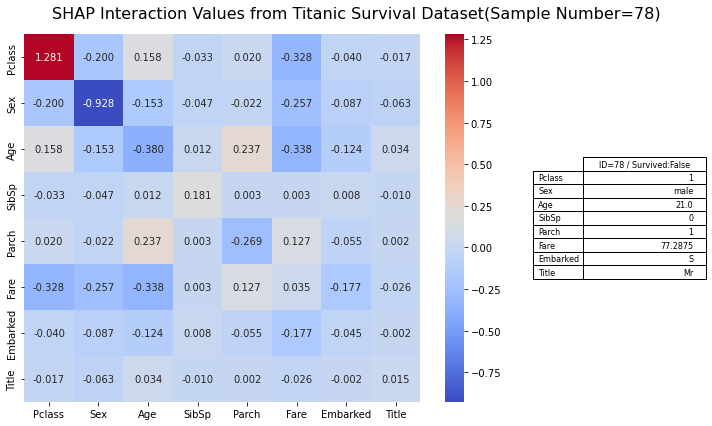

In [66]:
import matplotlib.gridspec as gridspec

df = pd.DataFrame(shap_interactions[data_id], index=feature_names, columns=feature_names)

fig = plt.figure(figsize=(10, 6))

gs1 = gridspec.GridSpec(1, 4)
ax1 = fig.add_subplot(gs1[0:3])
ax2 = fig.add_subplot(gs1[3])
sns.heatmap(df, cmap='coolwarm', annot=True, fmt='.3f', ax=ax1)
ax2.axis('tight')
ax2.axis('off')
ax2.table(cellText=sample.values, colLabels=sample.columns, loc='center', rowLabels=sample.index)
fig.suptitle(f'SHAP Interaction Values from Titanic Survival Dataset(Sample Number={i})', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
shap.summary_plot(shap_interactions.sum(2), dataset.data['X_train'])

In [ ]:
shap.summary_plot(shap_interactions, dataset.data['X_train'])

In [ ]:
# get tree from all train dataset
trees = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=5,  # select nodes_to_run & keys to filter 
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='random',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=True,
    verbose=False,
    thres_random=0.5
)
for tree in trees:
    img = tree.show_tree(dataset.feature_names)
    display(img)

In [ ]:
tree_builder.infos[2]['nodes_to_run']

In [ ]:
import statsmodels.api as sm

In [ ]:
from fge.functions import *
from fge.utils import flatten
from fge.fitter import PolyFitter
from fge.interaction_tree import ShapInteractionTree

from typing import Dict, Any, List
from copy import deepcopy
from collections import defaultdict
from tqdm import tqdm
from anytree import Node, TreeError
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, LabelBinarizer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

n_select_scores=5  # select nodes_to_run & keys to filter 
n_select_gap=5
nodes_to_run_method='random'
filter_method='prob'
siv_scores = tree_builder.score_methods['abs'](shap_interactions, True)
data = dataset.data

k = 3
prev_nodes_to_run = deepcopy(tree_builder.infos[k-1]['nodes_to_run'])
prev_nodes = deepcopy(tree_builder.infos[k-1]['nodes'])

# nodes_to_run = prev_nodes_to_run.pop(0)
# nodes = prev_nodes.pop(0)

i = 0
nodes_to_run = prev_nodes_to_run[i]
nodes = prev_nodes[i]

In [ ]:
scores = tree_builder.get_scores(siv_scores, nodes_to_run)
filtered_keys = tree_builder.filter_scores(scores, n_select_scores)

for cmbs in filtered_keys:
    combined_keys = list(filter(lambda x: isinstance(x, tuple), nodes.keys()))
    combined_keys_history = set()
    list(flatten(combined_keys, res=combined_keys_history))
    combined_keys_history = list(combined_keys_history)
    trials = combined_keys_history + [cmbs]
    gap = tree_builder.polyfitter.get_interaction_gap(trials)
    # all_gaps.append((gap, cmbs, deepcopy(nodes), summary))
    # if len(all_gaps) > n_select_gap:
    #     new_gaps = np.array(list(map(lambda x: x[0], all_gaps)))
    #     all_gaps = [all_gaps[i] for i in new_gaps.argsort() if i != n_select_gap]

In [ ]:
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

feature_names = data['X_train'].columns

def get_new_X(X_original, trials): 
    X = X_original.copy()
    for cmbs in trials:
        c_names = [feature_names[i] for i in flatten(cmbs)]
        X['+'.join(c_names)] = X.loc[:, c_names].prod(1)

    return X

def get_preprocessor(X):
    numerical_columns_selector = selector(dtype_include=np.float64, dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=np.int64)#pd.CategoricalDtype)
    numerical_columns = numerical_columns_selector(X)
    categorical_columns = categorical_columns_selector(X)
    categorical_preprocessor = OneHotEncoder(verbose=True, drop='first', handle_unknown='ignore', sparse=True) # FunctionTransformer(lambda x: x)
    numerical_preprocessor = StandardScaler()
    preprocessor = ColumnTransformer([
        ('onehot', categorical_preprocessor, categorical_columns),
        ('standard', numerical_preprocessor, numerical_columns)
    ])
    feature_names = categorical_columns + numerical_columns
    return preprocessor, feature_names 

In [ ]:
X_train = get_new_X(data['X_train'], trials)
X_test = get_new_X(data['X_test'], trials)
y_train = data['y_train']
y_test = data['y_test']
preprocessor, _ = get_preprocessor(X=X_train)
model = make_pipeline(preprocessor, LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred, y_test

In [ ]:
X_train_sm = preprocessor.fit_transform(X_train)
X_test_sm = preprocessor.transform(X_test)

In [ ]:
f_names = preprocessor.get_feature_names_out(X_train.columns)
f_names = [f.split('__')[1] for f in f_names]

In [ ]:
f_names

In [ ]:
X_train_sm = pd.DataFrame(X_train_sm.toarray(), index=X_train.index, columns=f_names)
# m = sm.Logit(y_train, sm.add_constant(X_train_sm)).fit()

In [ ]:
preprocessor, feature_names = get_preprocessor(X_train)

In [ ]:
X_train = preprocessor.fit_transform(X)
print(X_train.shape)
X_train = pd.DataFrame(X_train, index=X.index, columns=feature_names)
y_train = dataset.data['y_train']

In [ ]:
m = LogisticRegression().fit(X_train, y_train)

In [ ]:
m.predict(X_test)

In [ ]:
print(m.summary())

In [ ]:
X_train = self.preprocessor.fit_transform(self.data['X_train'])
self.X_train = pd.DataFrame(X_train, index=self.data['X_train'].index, columns=self.feature_names)

In [ ]:
for i, (nodes_to_run, nodes) in enumerate(zip(prev_nodes_to_run, prev_nodes)):
    scores = tree_builder.get_scores(siv_scores, nodes_to_run)
    filtered_keys = tree_builder.filter_scores(scores, n_select_scores)
    for cmbs in filtered_keys:
        combined_keys = list(filter(lambda x: isinstance(x, tuple), nodes.keys()))
        combined_keys_history = set()
        list(flatten(combined_keys, res=combined_keys_history))
        combined_keys_history = list(combined_keys_history)
        # trials = list(tree_builder.feature_names) + combined_keys_history + [cmbs]
        trials = combined_keys_history + [cmbs]
        # gap = tree_builder.polyfitter.get_interaction_gap(trials)
        break
    break
        # print(f'{cmbs}: {gap}')

In [ ]:
trials

In [ ]:
# fitter = tree_builder.polyfitter
feature_names = data['X_train'].columns

# Open ML

# Adult

In [86]:
seed = 8
dataset = Dataset(dataset_name='adult', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-logloss:0.53761
[40]	test-logloss:0.27630
[80]	test-logloss:0.28102
[120]	test-logloss:0.28647
[160]	test-logloss:0.29231
[199]	test-logloss:0.29741
test performance is 0.8674


In [78]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

In [79]:
from sklearn.metrics import r2_score, accuracy_score


In [82]:
X_train, y_train, X_test, y_test = dataset.data['X_train'], dataset.data['y_train'], dataset.data['X_test'], dataset.data['y_test']
preprocessor, _ = tree_builder.polyfitter.get_preprocessor(X_train)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
m = LogisticRegression(fit_intercept=False, max_iter=1000)
m.fit(X_train, y_train)

pred = m.predict(X_test)
print(accuracy_score(y_test, pred))

0.8467915259441203


In [83]:
0.8674 - 0.8468

0.02059999999999995

In [88]:
(0.8674 - 0.0117) 

0.8556999999999999

In [89]:
(0.8674 - 0.0117) - 0.8468

0.008899999999999908

In [90]:
group_id = None
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 29304, # of features = 12
Cost time: 1 mins 33.60 secs


In [91]:
# get tree from all train dataset
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=10,
    n_select_gap=10, 
    max_iter=8,
    nodes_to_run_method='random',  # random / sort / full
    filter_method='random',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)

Building Tree: 100%|██████████| 8/8 [06:59<00:00, 52.49s/it]


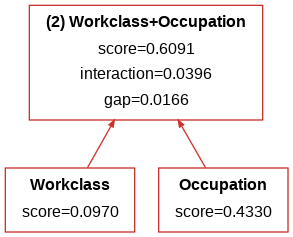

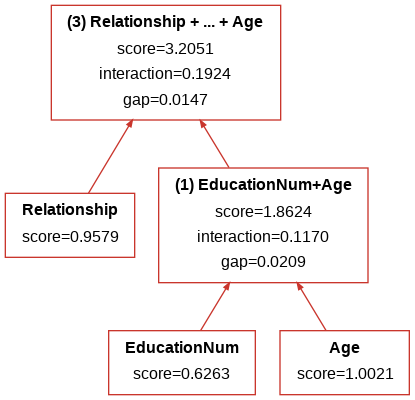

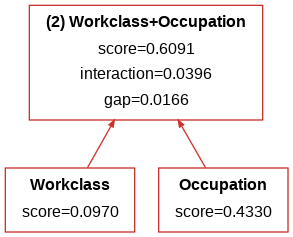

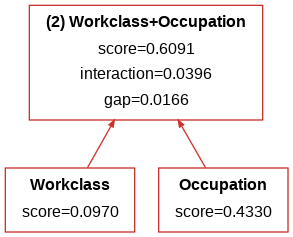

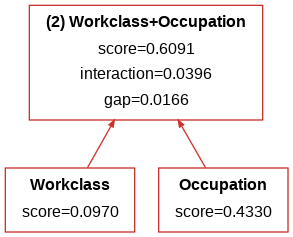

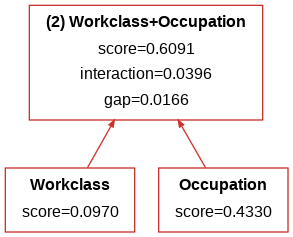

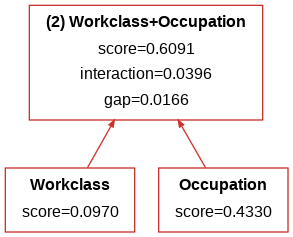

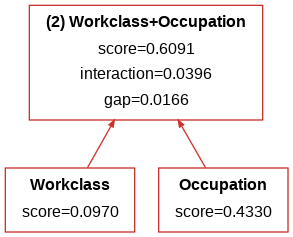

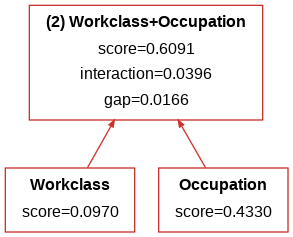

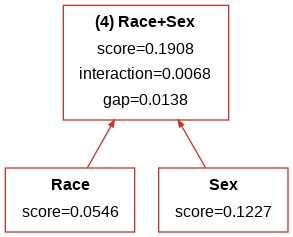

In [93]:
for t in tree:
    img = t[0].show_tree(dataset.feature_names)
    display(img)

---

## Group with labels equals to 0

In [ ]:
# get tree from group 0
group_id = 0
siv_adult_g0 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_adult_g0, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree.show_tree(feature_names=dataset.feature_names)

In [ ]:
display(img)

## Group with labels equals to 1

In [ ]:
# get tree from group 0
group_id = 1
siv_adult_g1 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_adult_g1, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree.show_tree(feature_names=dataset.feature_names)

In [ ]:
display(img)

# California

In [ ]:
from sklearn.datasets import fetch_california_housing
data_path = Path('../data').resolve()
dataset = fetch_california_housing(data_home=data_path / 'california', as_frame=True)
X = dataset['data'].copy()
y = dataset['target']

In [ ]:
dataset.data['X_train'].columns

In [ ]:
seed = 8
dataset = Dataset(dataset_name='california', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

In [ ]:
# get tree from group 0
group_id = 0
siv_cali_g0 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_cali_g0, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree[0][0].show_tree(feature_names=dataset.feature_names)
img

In [ ]:
sns.histplot(dataset[group_id]['y_train'])

In [ ]:
display(img)

In [ ]:
# get tree from group 3
group_id = 3
siv_cali_g3 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_cali_g3, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree.show_tree(feature_names=dataset.feature_names)

In [ ]:
sns.histplot(dataset[group_id]['y_train'])

In [ ]:
display(img)

# Boston

In [ ]:
dataset.data['X_train'].columns

In [ ]:
seed = 8
dataset = Dataset(dataset_name='boston', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.1, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [ ]:
# get tree from group 0
group_id = 0
siv_bos_g0 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
sns.histplot(dataset[group_id]['y_train'])

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_bos_g0, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

In [ ]:
# get tree from group 3
group_id = 3
siv_bos_g3 = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
sns.histplot(dataset[group_id]['y_train'])

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=siv_bos_g3, 
    n_select_scores=5,
    n_select_gap=5, 
    max_iter=None,
    nodes_to_run_method='full',  # random / sort / full
    filter_method='prob',  # random / sort / prob
    rt_only_best=False,
    verbose=False
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

---

# Not ready yet

# Crime

In [ ]:
seed = 8
dataset = Dataset(dataset_name='crime', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=400)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

In [ ]:
# get tree from group 0
group_id = 0
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
sns.histplot(dataset[group_id]['y_train'])

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=5,
    n_select_performance=5, 
    max_iter=None,
    initialize=None,
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

In [ ]:
len(list(tree_builder.infos[97]['nodes'][0].keys()))

# nhanesi

In [ ]:
seed = 8
dataset = Dataset(dataset_name='nhanesi', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.05, max_depth=8, subsample=1.0, seed=seed, num_rounds=400)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import itertools
X_train, X_test = dataset.data['X_train'].copy(), dataset.data['X_test'].copy()
poly = PolynomialFeatures(2, interaction_only=True, include_bias=True)
X_train_full, X_test_full = poly.fit_transform(X_train), poly.fit_transform(X_test)

In [ ]:
X_train.iloc[:, :3]

In [ ]:
len(list(itertools.combinations(np.arange(X_train.shape[1]), 2)))

In [ ]:
X_train_full[:, :3]

In [ ]:
# get tree from group 0
group_id = 0
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

In [ ]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=5,
    n_select_performance=5, 
    max_iter=25,
    initialize='random',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

In [ ]:
tree_builder.infos[1]['nodes_to_run'][0][25:]

## Debug

In [ ]:
from anytree import Node

In [ ]:
tree_builder.reset_tree(False)
k=0
g_fn = tree_builder.score_methods['abs']
# feature settings

if shap_interactions.ndim == 3:
    # ndim == 3 case: global tree
    build_global = True
elif shap_interactions.ndim == 2:
    # ndim == 2 case: single tree
    build_global = False
else:
    raise ValueError('number of dimension of `shap_interactions` should be 2 or 3')

siv_scores = g_fn(shap_interactions, build_global)
max_iter = 10
r_diag, c_diag = np.diag_indices(len(tree_builder.feature_names))
main_effect = siv_scores[r_diag, c_diag]
tree_builder.infos[k]['nodes'] = [dict()]
tree_builder.infos[k]['done'] = [set()]
for i, name in enumerate(tree_builder.feature_names):
    tree_builder.infos[k]['nodes'][0][i] = Node(
        name=name, parent=None, score=main_effect[i], interaction=0.0, k=0, drop=0.0
    )

---